In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from pathlib import Path

warnings.filterwarnings('ignore')

In [3]:
source_path = Path('./')

# Dữ liệu

In [ ]:
processed_dataset_path = source_path.parent / 'processedDataset'

train_df = pd.read_parquet(processed_dataset_path / 'train_data.parquet')
train_df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,NaN,0,0.000610,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,-1,0,0,0.0,NaN,0,0.005492,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,-1,0,0,0.0,NaN,0,0.006986,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,-1,0,0,0.0,NaN,0,0.006527,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,-1,0,0,0.0,NaN,0,0.008126,0


# Khai phá dữ liệu

## Số lượng giao dịch và khách hàng

In [ ]:
number_transaction = train_df.shape[0]
number_customer = train_df['customer_ID'].nunique()

print(f'Tổng số giao dịch : {number_transaction}')
print(f'Số khách hàng : {number_customer}')

Tổng số giao dịch : 5531451
Số khách hàng : 458913


## Các giá trị bị thiếu 

In [ ]:
train_df.isnull().sum()

customer_ID          0
S_2                  0
P_2              45985
D_39                 0
B_1                  0
                ...   
D_141           101548
D_142          4587043
D_143                0
D_144            40727
D_145                0
Length: 190, dtype: int64

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 190 entries, customer_ID to D_145
dtypes: float32(93), int16(9), int8(86), object(2)
memory usage: 2.5+ GB


In [ ]:
def show_missing(data):
    ''' This function is used to show percentage of missing data. '''
    missing_values = data.isnull().sum()

    percent_missing = missing_values / data.shape[0] * 100
    percent_missing = percent_missing.round(2) 

    show_missing = pd.concat([missing_values, percent_missing, data.dtypes], 
                           keys=['Quantity', 'Percentage', 'Type'], axis = 1)

    return show_missing

missing_table = show_missing(train_df)
missing_table

,Quantity,Percentage,Type
customer_ID,0,0.00,object
S_2,0,0.00,object
P_2,45985,0.83,float32
D_39,0,0.00,int16
B_1,0,0.00,float32
...,...,...,...
D_141,101548,1.84,float32
D_142,4587043,82.93,float32
D_143,0,0.00,int8
D_144,40727,0.74,float32


In [ ]:
threshold = 60
large_missing_table = missing_table[missing_table['Percentage'] >= threshold].sort_values(by=['Percentage'], ascending=False)
large_missing_table

,Quantity,Percentage,Type
D_88,5525447,99.89,float32
D_110,5500117,99.43,float32
B_39,5497819,99.39,float32
D_73,5475595,98.99,float32
B_42,5459973,98.71,float32
D_134,5336752,96.48,float32
B_29,5150035,93.10,float32
D_132,4988874,90.19,float32
D_76,4908954,88.75,float32
D_42,4740137,85.69,float32


Như vậy, có tới 12 trường dữ liệu có giá trị không xác định lên tới hơn 60%. Những trường dữ liệu này cơ bản sẽ không mang lại nhiều giá trị trong quá trình xấy dựng mô hình, nên nhóm sẽ loại bỏ những trường dữ liệu này. 

In [ ]:
removed_columns = large_missing_table.index.to_list()

# Loại bỏ các cột dữ liệu bị thiếu quá nhiều
train_df = train_df.drop(columns=removed_columns)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 178 entries, customer_ID to D_145
dtypes: float32(81), int16(9), int8(86), object(2)
memory usage: 2.3+ GB


In [ ]:
# Tiếp theo đây, ta sẽ xem xét các cột có giá trị null để xử lý
remain_table = missing_table[(0 < missing_table['Percentage']) & (missing_table['Percentage'] < threshold)]
considered_columns = remain_table.index.to_list()
len(considered_columns)

49

## Xử lý giá trị id và date 
Vì với dữ liệu hiện tại, các id đang bị lặp lại do thực hiện nhiêu giao dịch, do đo cần xử lý để đưa các id này về duy nhất. Và hướng tiếp cận là:
- Với các biến liên tục, ta sẽ nhóm theo id và lấy tổng 
- Với các biến rời rạc, ta sẽ nhóm theo id và lấy max level 

Còn đối với trường dữ liệu về ngày (tức S_2) tạm thời sẽ bị loại bỏ

In [ ]:
categorical_columns = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
numeric_columns = list(set(train_df.columns).difference(categorical_columns + ['customer_ID', 'S_2']))

In [ ]:
# Bỏ cột date 
train_df = train_df.drop(columns=['S_2'])

map_functions = {}
for column in train_df.columns:
    if column == 'customer_ID':
        continue
    elif column in categorical_columns:
        map_functions[column] = 'max'
    else:
        map_functions[column] = 'sum'

In [ ]:
groupby_data = train_df.groupby('customer_ID').agg(map_functions)
groupby_data.head()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,...,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_143,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,12.139710,3,0.156094,13.066114,0.058611,1.471796,0.0,0.083931,0.000000,0.0,...,-13,-13,-13,-13,0,0,0.0,0,0.068683,0.0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,11.697656,93,0.333500,12.884082,0.081203,1.567520,0.0,0.073624,1.011999,0.0,...,-13,-13,-13,-13,0,0,0.0,0,0.054835,0.0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,11.419907,0,0.057017,10.603799,0.086070,0.000000,0.0,0.071407,0.000000,1.0,...,-13,-13,-13,-13,0,0,0.0,0,0.066470,0.0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,7.786597,20,0.778394,12.418438,0.073649,3.220751,0.0,0.083493,0.793337,0.0,...,-13,-13,-13,-13,0,0,0.0,0,0.061985,0.0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,11.591827,0,0.077228,10.589060,0.054335,0.692407,0.0,0.066144,0.634108,0.0,...,-13,-13,-13,-13,0,0,0.0,0,0.056941,0.0


In [ ]:
groupby_data

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,...,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_143,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,12.139710,3,0.156094,13.066114,0.058611,1.471796,0.000000,0.083931,0.000000,0.0,...,-13,-13,-13,-13,0,0,0.000000,0,0.068683,0.0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,11.697656,93,0.333500,12.884082,0.081203,1.567520,0.000000,0.073624,1.011999,0.0,...,-13,-13,-13,-13,0,0,0.000000,0,0.054835,0.0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,11.419907,0,0.057017,10.603799,0.086070,0.000000,0.000000,0.071407,0.000000,1.0,...,-13,-13,-13,-13,0,0,0.000000,0,0.066470,0.0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,7.786597,20,0.778394,12.418438,0.073649,3.220751,0.000000,0.083493,0.793337,0.0,...,-13,-13,-13,-13,0,0,0.000000,0,0.061985,0.0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,11.591827,0,0.077228,10.589060,0.054335,0.692407,0.000000,0.066144,0.634108,0.0,...,-13,-13,-13,-13,0,0,0.000000,0,0.056941,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,11.033751,50,0.379339,13.067154,0.070950,1.637758,0.000000,0.075576,1.067959,0.0,...,-13,-13,-13,-13,0,0,0.000000,0,0.072861,0.0
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,11.171254,27,4.788349,0.550651,0.072049,1.915676,0.000000,3.535716,0.655039,13.0,...,-13,-13,-13,-13,0,0,0.000000,0,0.078672,0.0
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,10.228889,96,0.559405,11.112572,0.061769,1.097000,2.356029,0.748077,1.576450,0.0,...,-13,-13,-13,-13,-1,0,0.000000,-1,0.063182,-1.0


# Xây dựng luồng cử lý giá trị null và các cột categorical

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler



# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = SimpleImputer(strategy='most_frequent')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler())
    ]
)

# Pipeline
optimal_data = pipeline.fit_transform(groupby_data)

In [ ]:
optimal_data_df = pd.DataFrame(optimal_data, columns=groupby_data.columns, index=groupby_data.index)
optimal_data_df

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,...,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_143,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,-0.788939,-0.468222,-0.786991,-1.310168,0.678214,-0.12599,-0.521143,0.227303,-0.352152,-0.308827,...,-0.748848,0.744711,0.050315,0.493393,-0.541061,0.41896,-2.268295,-1.026770,-0.381437,0.647739
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,-0.309152,-0.456353,-0.786991,-0.445812,0.678214,-0.12599,-0.521143,-0.135870,-0.352152,-0.308827,...,-0.748848,0.744711,0.050315,-1.863418,1.662818,0.41896,0.299443,-1.026770,-0.381437,0.647739
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.930298,-0.453795,-0.786991,-0.445812,0.678214,-0.12599,-0.521143,-0.236615,-0.352152,-0.308827,...,-1.287468,0.744711,0.050315,-1.863418,-0.541061,0.41896,0.299443,0.394205,-0.381437,0.647739
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.450511,-0.460321,0.000363,0.679483,-0.474663,-0.12599,-0.521143,0.036956,-0.352152,-0.308827,...,-0.748848,0.744711,0.050315,1.436118,-0.541061,0.41896,0.299443,-1.026770,-0.381437,0.647739
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.770369,-0.470468,-0.786991,0.320693,0.678214,-0.12599,-0.521143,-0.236766,-0.352152,-0.308827,...,-0.748848,0.744711,0.050315,0.493393,-0.541061,0.41896,0.299443,-1.026770,2.704927,0.647739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,-0.109241,-0.461739,-0.786991,-0.095177,0.678214,-0.12599,-0.521143,0.298288,-0.352152,-0.308827,...,-0.748848,-1.234198,0.050315,0.493393,1.662818,0.41896,0.299443,1.104692,2.704927,0.647739
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0.770369,-0.461161,1.634591,0.320693,0.678214,-0.12599,1.809914,-0.194166,-0.352152,-0.308827,...,1.944252,0.744711,0.050315,0.022031,-0.541061,0.41896,0.299443,0.394205,-0.381437,0.647739
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,-0.708974,-0.466562,-0.022629,-0.127794,-1.161257,-0.12599,-0.521143,0.064601,-0.352152,-0.308827,...,-0.210228,0.744711,0.050315,-1.863418,-0.541061,0.41896,0.299443,1.104692,-0.381437,-0.102841


In [23]:
optimal_dataset_path = source_path.parent / 'optimalDataset'
optimal_data_df.reset_index().to_parquet(optimal_dataset_path / 'data.parquet', index=False)

In [24]:
optimal_data_df.reset_index().columns

Index(['customer_ID', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3',
       'D_43',
       ...
       'D_135', 'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_143',
       'D_144', 'D_145'],
      dtype='object', length=177)

# Thống kê về nhãn phân lớp

In [ ]:
labels = pd.read_csv(optimal_dataset_path / 'labels.csv')
labels

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0
...,...,...
458908,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,0
458909,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,0
458910,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,0
458911,ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf38814...,1


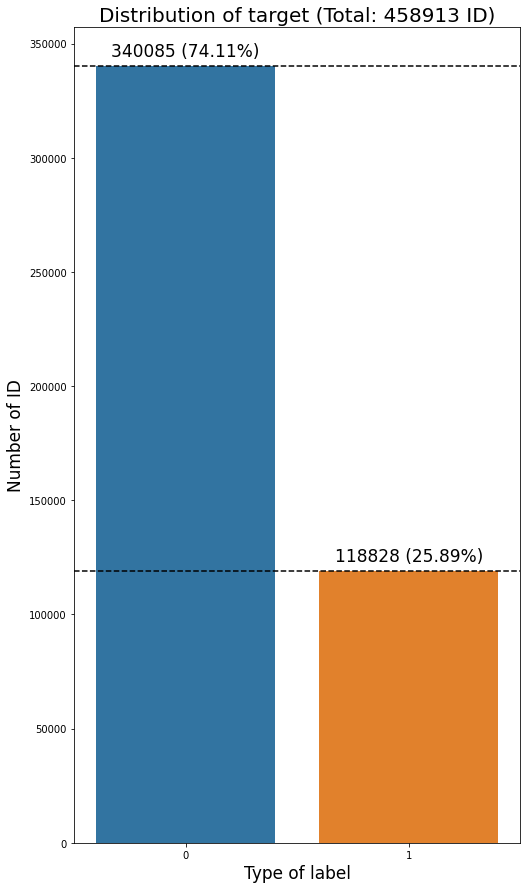

In [ ]:
plt.figure(figsize=(8, 15))

number_neg = np.sum(labels['target'] == 0)
number_pos = np.sum(labels['target'] == 1)
number_dis = [number_neg, number_pos]


sns.countplot(labels['target'])
for i, value in enumerate(number_dis):
    percentage = np.round(value / sum(number_dis) * 100, 2)
    plt.annotate(f'{value} ({percentage}%)', (i, value + sum(number_dis) * 0.01), ha='center', fontsize=17)
    plt.axhline(y=value, color='black', linestyle='--')

plt.xlabel('Type of label', fontsize=17)
plt.ylabel('Number of ID', fontsize=17)
plt.title(f'Distribution of target (Total: {sum(number_dis)} ID)', fontsize=20)
plt.savefig('distributionTarget.png', bbox_inches='tight')